# EE 344 — Assignment 5: Power-System Fault Classification with Deep Neural Networks

In this assignment, you will predict **power-system fault conditions** from 6 input measurements using **PyTorch**.
There are many ways to implement DNNs for prediction tasks; here you will implement and compare **three** common setups.

**Dataset**: `classData.csv`

**Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`  
**Outputs**: 4-bit label `[G, C, B, A]`

Dataset (Kaggle): https://www.kaggle.com/datasets/esathyaprakash/electrical-fault-detection-and-classification

**Note:** Do **NOT** download the dataset from Kaggle. Use the dataset file provided on Canvas with this assignment.

Your tasks:
1. **Part 1** — Regression-style DNN to predict 4 outputs (then round to bits).
2. **Part 2** — Multi-label DNN to predict 4 bits (sigmoid / BCE-style loss).
3. **Part 3** — Multi-class DNN to predict no fault and 5 fault types (softmax / cross-entropy).
4. **Part 4** — Brief discussion: which approach is best and why.
5. **Part 5** — Open-ended: build a **binary** classifier (Fault vs No Fault) using the best approach.


## Setup
Run the next cell to import libraries and define helper functions.

In [42]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def plot_cm(cm, title, labels):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha='right')
    plt.yticks(ticks, labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def bit_reports(Y_true_bits, Y_pred_bits, split_name='Test', bit_names=('G','C','B','A')):
    """Multi-label report + per-bit 2x2 confusion matrices."""
    print(f"\n=== Bit-level Report | {split_name} ===")
    print(classification_report(Y_true_bits, Y_pred_bits, target_names=list(bit_names), digits=4))
    for j, lab in enumerate(bit_names):
        cm = confusion_matrix(Y_true_bits[:, j], Y_pred_bits[:, j], labels=[0, 1])
        print(f"\nBit {lab} | {split_name} CM (rows=true 0/1, cols=pred 0/1):\n{cm}")


Device: cpu


## Dataset

The file `classData.csv` contains a dataset for classifying fault conditions.

- **Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`
- **Outputs**: `[G, C, B, A]`

Examples:
- `[0 0 0 0]` — No Fault
- `[1 0 0 1]` — LG fault (Phase A to ground)
- `[0 0 1 1]` — LL fault (Phase A to Phase B)
- `[1 0 1 1]` — LLG fault (Phases A,B to ground)
- `[0 1 1 1]` — LLL fault (all three phases)
- `[1 1 1 1]` — LLLG fault (three phases + ground)


In [43]:
# ----------------------------
# Load data + create targets
# ----------------------------
CSV_PATH = 'classData.csv'
df = pd.read_csv(CSV_PATH)

label_cols = ['G','C','B','A']
feature_cols = ['Ia','Ib','Ic','Va','Vb','Vc']

missing = [c for c in (label_cols + feature_cols) if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}. Found: {list(df.columns)}")

X = df[feature_cols].astype(np.float32).values            # (N,6)
Y_bits = df[label_cols].astype(int).values                # (N,4)

FAULT_NAMES = ['No Fault','LG','LL','LLG','LLL','LLLG']

def bits_to_fault_type_idx(bits_gcba):
    G, C, B, A = map(int, bits_gcba)
    n_phase = C + B + A
    if G == 0 and n_phase == 0: return 0
    if G == 1 and n_phase == 1: return 1
    if G == 0 and n_phase == 2: return 2
    if G == 1 and n_phase == 2: return 3
    if G == 0 and n_phase == 3: return 4
    if G == 1 and n_phase == 3: return 5
    raise ValueError(f"Unexpected pattern [G,C,B,A]={bits_gcba}")

y_fault = np.array([bits_to_fault_type_idx(row) for row in Y_bits], dtype=int)
print('Fault counts:', dict(zip(FAULT_NAMES, np.bincount(y_fault, minlength=len(FAULT_NAMES)))))

# One shared split (recommended for fair comparison across Parts 1–3)
X_train, X_test, Y_train, Y_test, y_fault_train, y_fault_test = train_test_split(
    X, Y_bits, y_fault, test_size=0.30, random_state=RANDOM_STATE, stratify=y_fault
)
print('Train size:', X_train.shape[0], '| Test size:', X_test.shape[0])


Fault counts: {'No Fault': np.int64(2365), 'LG': np.int64(1129), 'LL': np.int64(1004), 'LLG': np.int64(1134), 'LLL': np.int64(1096), 'LLLG': np.int64(1133)}
Train size: 5502 | Test size: 2359


## Part 1 — DNN Model 1 (Regression-style 4-output model)

You will build a DNN that outputs **4 real-valued numbers** and train it with **MSE**.
During evaluation, you will **round** predictions to the nearest integer, clamp to `{0,1}`, and then compare against the true 4-bit label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 (linear)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**


In [44]:
# ----------------------------
# Part 1: Robust scaling (fit on train only)
# ----------------------------
scaler_1 = RobustScaler()
X_train_s1 = scaler_1.fit_transform(X_train).astype(np.float32)
X_test_s1  = scaler_1.transform(X_test).astype(np.float32)

# Torch datasets
Xtr = torch.from_numpy(X_train_s1)
Xte = torch.from_numpy(X_test_s1)
Ytr = torch.from_numpy(Y_train.astype(np.float32))
Yte = torch.from_numpy(Y_test.astype(np.float32))

BATCH_SIZE = 256
train_loader_1 = DataLoader(TensorDataset(Xtr, Ytr), batch_size=BATCH_SIZE, shuffle=True)

# Hyperparameters
INPUT_DIM = 6
H1 = 16
H2 = 8
OUT_DIM = 4
DROPOUT_P = 0.25
L2_WEIGHT_DECAY = 1e-4
LR = 1e-3
EPOCHS = 1000


In [45]:
## [ TODO 1 ]
# Define the DNN for Part 1 using PyTorch.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: linear (no activation)
# - Use BatchNorm and Dropout in hidden layers
#
# Write your model class below.

class DNN_Reg4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        # TODO: define layers (Linear, BatchNorm1d, Dropout, etc.)
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.drop1 = nn.Dropout(p_drop)
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.drop2 = nn.Dropout(p_drop)
        self.fc3 = nn.Linear(h2, out_dim)

    def forward(self, x):
        # TODO: implement forward pass
        x = self.drop1(torch.relu(self.bn1(self.fc1(x))))
        x = self.drop2(torch.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        return x

In [46]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: MSE
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

model = DNN_Reg4(input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)

In [47]:
# ----------------------------
# Training loop (you fill the key missing pieces)
# ----------------------------
## [ TODO 3 ]
def train_part1(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            optimizer.zero_grad()
            # TODO: forward pass
            outputs = model(xb)
            # TODO: compute loss
            loss = loss_fn(outputs, yb)
            # TODO: backward
            loss.backward()
            # TODO: optimizer step
            optimizer.step()

            total += loss.item() * xb.size(0)

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            print(f"Epoch {ep}/{epochs}, Loss: {total/len(loader.dataset):.4f}")

@torch.no_grad()
def predict_part1(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    out = model(X_t).cpu().numpy()  # (N,4) real-valued
    return out

# TODO: Train the model
train_part1(model, train_loader_1, epochs=EPOCHS)

Epoch 1/1000, Loss: 0.7661
Epoch 500/1000, Loss: 0.1027
Epoch 1000/1000, Loss: 0.1029


In [48]:
# ----------------------------
# Evaluation (round -> clamp to {0,1} -> report)
# ----------------------------
yhat_train = predict_part1(model, X_train_s1)
yhat_test  = predict_part1(model, X_test_s1)

# After you obtain yhat_* (shape N x 4):
pred_bits_train = np.clip(np.rint(yhat_train).astype(int), 0, 1)
pred_bits_test  = np.clip(np.rint(yhat_test ).astype(int), 0, 1)
bit_reports(Y_train, pred_bits_train, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.8992    0.7690    0.8290      2377
           C     0.9924    0.9174    0.9534      2263
           B     0.9452    0.9653    0.9552      3057
           A     0.9781    0.9793    0.9787      3144

   micro avg     0.9557    0.9163    0.9356     10841
   macro avg     0.9537    0.9078    0.9291     10841
weighted avg     0.9545    0.9163    0.9340     10841
 samples avg     0.6610    0.6477    0.6486     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2920  205]
 [ 549 1828]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3223   16]
 [ 187 2076]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2274  171]
 [ 106 2951]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2289   69]
 [  65 3079]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.8995    0.7556    0.8213      1019
           C     0.9845    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

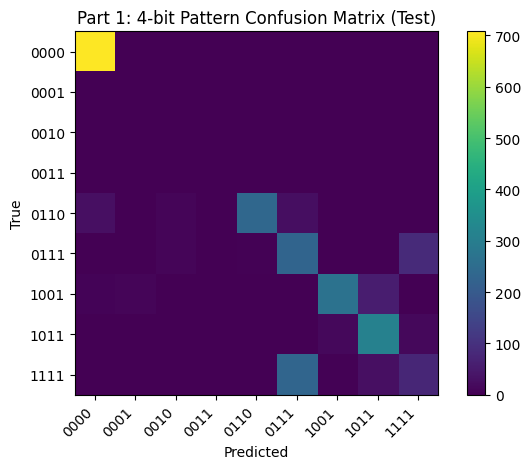

[[708   1   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 28   0  11   0 237  25   0   0   0]
 [  0   0  11   0   4 229   0   0  85]
 [  7   9   0   0   0   0 266  57   0]
 [  0   0   0   1   0   0  14 311  14]
 [  0   0   0   0   0 232   4  29  75]]


In [49]:
# One confusion matrix over full 4-bit patterns (for TEST set)
true_str = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str = [''.join(map(str, r.tolist())) for r in pred_bits_test]
labels = sorted(list(set(true_str) | set(pred_str)))
cm = confusion_matrix(true_str, pred_str, labels=labels)
plot_cm(cm, 'Part 1: 4-bit Pattern Confusion Matrix (Test)', labels)
print(cm)

## Part 2 — DNN Model 2 (Multi-label 4-bit classification)

You will build a DNN that predicts the 4 bits `[G, C, B, A]` as a **multi-label** output.
Each output dimension is an independent binary label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 logits (apply sigmoid only for evaluation)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use a **binary cross-entropy style loss on logits** (do not apply sigmoid inside the model).


In [50]:
# ----------------------------
# Part 2: Robust scaling (fit on train only)
# ----------------------------
scaler_2 = RobustScaler()
X_train_s2 = scaler_2.fit_transform(X_train).astype(np.float32)
X_test_s2  = scaler_2.transform(X_test).astype(np.float32)

Xtr2 = torch.from_numpy(X_train_s2)
Xte2 = torch.from_numpy(X_test_s2)
Ytr2 = torch.from_numpy(Y_train.astype(np.float32))
Yte2 = torch.from_numpy(Y_test.astype(np.float32))

train_loader_2 = DataLoader(TensorDataset(Xtr2, Ytr2), batch_size=BATCH_SIZE, shuffle=True)


In [51]:
class DNN_MultiLabel4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        # TODO: define layers
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.drop1 = nn.Dropout(p_drop)
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.drop2 = nn.Dropout(p_drop)
        self.fc3 = nn.Linear(h2, out_dim)

    def forward(self, x):
        # TODO: forward pass returning logits (N,4)
        x = self.drop1(torch.relu(self.bn1(self.fc1(x))))
        x = self.drop2(torch.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        return x

In [52]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: binary cross-entropy style loss on logits -- BCEWithLogitsLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

model = DNN_MultiLabel4(input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)

In [53]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3]
def train_part2(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            optimizer.zero_grad()
            # TODO: logits = model(xb)
            logits = model(xb)
            # TODO: loss = loss_fn(logits, yb)
            loss = loss_fn(logits, yb)
            # TODO: backward + step
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            print(f"Epoch {ep}/{epochs}, Loss: {total/len(loader.dataset):.4f}")

@torch.no_grad()
def predict_bits_part2(model, X_np, threshold=0.5):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy()
    pred_bits = (probs >= threshold).astype(int)
    return pred_bits

# TODO: Train the model
train_part2(model, train_loader_2, epochs=EPOCHS)

Epoch 1/1000, Loss: 0.7090
Epoch 500/1000, Loss: 0.2183
Epoch 1000/1000, Loss: 0.2014


In [54]:
# ----------------------------
# Evaluation
# ----------------------------
pred_bits_train_ = predict_bits_part2(model, X_train_s2)
pred_bits_test_  = predict_bits_part2(model, X_test_s2)

bit_reports(Y_train, pred_bits_train_, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test_,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.8363    0.8443    0.8403      2377
           C     1.0000    0.9129    0.9545      2263
           B     0.9975    0.9313    0.9633      3057
           A     0.9997    0.9777    0.9886      3144

   micro avg     0.9614    0.9219    0.9412     10841
   macro avg     0.9584    0.9166    0.9367     10841
weighted avg     0.9633    0.9219    0.9418     10841
 samples avg     0.6679    0.6510    0.6548     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2732  393]
 [ 370 2007]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3239    0]
 [ 197 2066]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2438    7]
 [ 210 2847]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2357    1]
 [  70 3074]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.8373    0.8283    0.8328      1019
           C     1.0000    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

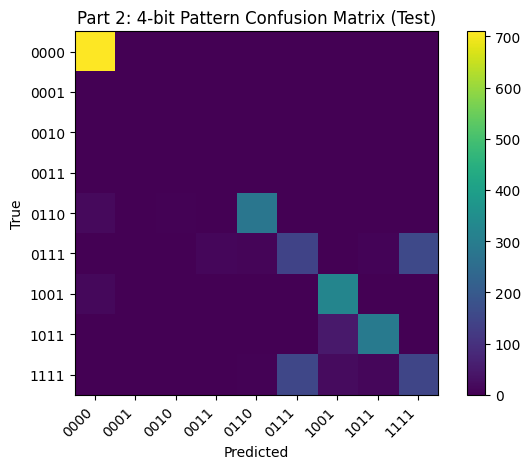

[[710   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 18   0   4   0 279   0   0   0   0]
 [  0   0   0  13  10 142   0   7 157]
 [ 15   2   0   0   0   0 322   0   0]
 [  0   1   0   0   0   0  48 291   0]
 [  0   0   0   0   5 152  22  12 149]]


In [55]:
# One confusion matrix over full 4-bit patterns (For TEST set)
true_str_ = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str_ = [''.join(map(str, r.tolist())) for r in pred_bits_test_]
labels_ = sorted(list(set(true_str_) | set(pred_str_)))
cm_ = confusion_matrix(true_str_, pred_str_, labels=labels_)
plot_cm(cm_, 'Part 2: 4-bit Pattern Confusion Matrix (Test)', labels_)
print(cm_)

## Part 3 — DNN Model 3 (Multi-class fault type classification)

In this part, you will predict one of **6 fault types**.
The 4-bit label is converted to a single class in `{0,1,2,3,4,5}` using the provided mapping.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 6 logits
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use **cross-entropy loss** for multi-class classification.


In [56]:
# ----------------------------
# Part 3: Robust scaling (fit on train only)
# ----------------------------
scaler_3 = RobustScaler()
X_train_s3 = scaler_3.fit_transform(X_train).astype(np.float32)
X_test_s3  = scaler_3.transform(X_test).astype(np.float32)

ytr3 = torch.from_numpy(y_fault_train.astype(np.int64))
yte3 = torch.from_numpy(y_fault_test.astype(np.int64))
Xtr3 = torch.from_numpy(X_train_s3)
Xte3 = torch.from_numpy(X_test_s3)

train_loader_3 = DataLoader(TensorDataset(Xtr3, ytr3), batch_size=BATCH_SIZE, shuffle=True)


In [57]:
## [ TODO 1 ]
# Define the DNN for Part 3.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 6
# - Hidden activations: ReLU
# - Output: 6 logits
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiClass6(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, num_classes=6, p_drop=DROPOUT_P):
        super().__init__()
        # TODO: define layers
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.drop1 = nn.Dropout(p_drop)
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.drop2 = nn.Dropout(p_drop)
        self.fc3 = nn.Linear(h2, num_classes)

    def forward(self, x):
        # TODO: forward pass returning logits (N,6)
        x = self.drop1(torch.relu(self.bn1(self.fc1(x))))
        x = self.drop2(torch.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        return x

In [58]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: CrossEntropyLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

model = DNN_MultiClass6(input_dim=INPUT_DIM, h1=H1, h2=H2, num_classes=6, p_drop=DROPOUT_P).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)

In [59]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3 ]
def train_part3(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            optimizer.zero_grad()
            # TODO: logits = model(xb)
            logits = model(xb)
            # TODO: loss = loss_fn(logits, yb)
            loss = loss_fn(logits, yb)
            # TODO: backward + step
            loss.backward()
            optimizer.step()

            total += loss.item() * xb.size(0)

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            print(f"Epoch {ep}/{epochs}, Loss: {total/len(loader.dataset):.4f}")

@torch.no_grad()
def predict_part3(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    return torch.argmax(logits, dim=1).cpu().numpy()

# TODO: Train the model
train_part3(model, train_loader_3, epochs=EPOCHS)

Epoch 1/1000, Loss: 1.8517
Epoch 500/1000, Loss: 0.5962
Epoch 1000/1000, Loss: 0.6071



=== Part 3 | Train ===
              precision    recall  f1-score   support

    No Fault     0.9484    1.0000    0.9735      1655
          LG     0.8594    0.9443    0.8999       790
          LL     0.9038    0.9360    0.9196       703
         LLG     0.8829    0.9018    0.8922       794
         LLL     0.5426    0.5150    0.5284       767
        LLLG     0.5048    0.3960    0.4438       793

    accuracy                         0.8150      5502
   macro avg     0.7737    0.7822    0.7763      5502
weighted avg     0.8000    0.8150    0.8059      5502



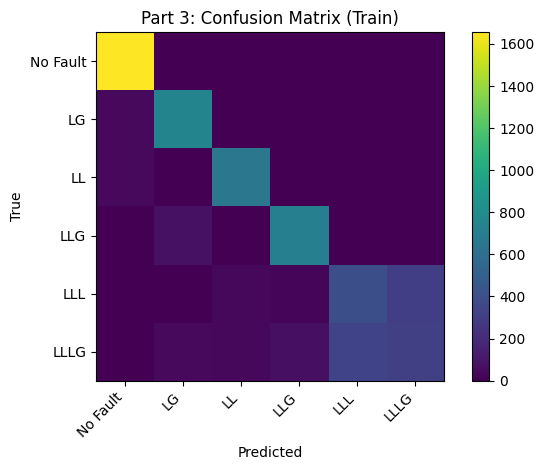


=== Part 3 | Test ===
              precision    recall  f1-score   support

    No Fault     0.9441    1.0000    0.9713       710
          LG     0.8645    0.9410    0.9011       339
          LL     0.9094    0.9336    0.9213       301
         LLG     0.9059    0.9059    0.9059       340
         LLL     0.5143    0.4924    0.5031       329
        LLLG     0.4854    0.3912    0.4332       340

    accuracy                         0.8109      2359
   macro avg     0.7706    0.7773    0.7727      2359
weighted avg     0.7967    0.8109    0.8026      2359



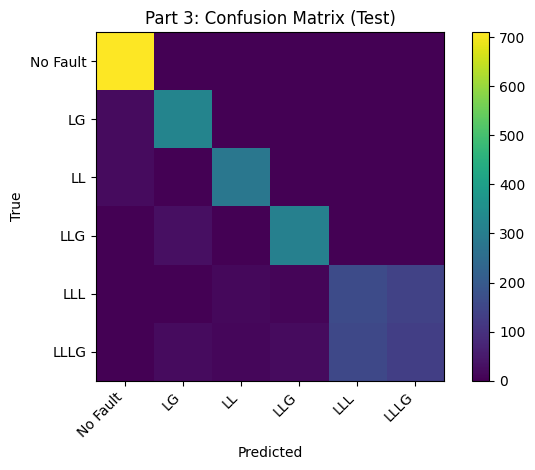

In [60]:
# ----------------------------
# Evaluation
# ----------------------------
pred_train = predict_part3(model, X_train_s3)
pred_test  = predict_part3(model, X_test_s3)

print('\n=== Part 3 | Train ===')
print(classification_report(y_fault_train, pred_train, target_names=FAULT_NAMES, digits=4))
cm_tr = confusion_matrix(y_fault_train, pred_train, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_tr, 'Part 3: Confusion Matrix (Train)', FAULT_NAMES)

print('\n=== Part 3 | Test ===')
print(classification_report(y_fault_test, pred_test, target_names=FAULT_NAMES, digits=4))
cm_te = confusion_matrix(y_fault_test, pred_test, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_te, 'Part 3: Confusion Matrix (Test)', FAULT_NAMES)


## Part 4 — Discussion

Answer **2–5 sentences** for each prompt.

1. Compare Parts 1–3. Which formulation fits this dataset best (regression-style, multi-label, or multi-class), and why?
2. When you used the bit-based approaches (Part 1 and Part 2), did you observe any **inconsistent 4-bit outputs** (invalid fault patterns)? What does that suggest?
3. Looking at confusion matrices, which fault types (or bit positions) were the hardest to predict? Give one plausible reason.

### Your answers
- Q1:The multi-label classification in part 2 appears to fit this dataset best. It achieved the highest macro average F1-score for individual bits, indicating better overall accuracy in predicting the 4-bit pattern compared to the regression-style approach in part 1. While Part 3 directly classifies fault types, its performance was significantly lower and struggled particularly with LLL and LLLG fault types, suggesting the direct multi-class formulation might be too restrictive or prone to misclassification for similar fault types.
- Q2: Yes, inconsistent 4-bit outputs were observed in both Part 1 and Part 2, primarily in the confusion matrix labels for the test set. Specifically, patterns like 0001 and 0010 were present in the predicted outputs, even though they are not defined as valid fault types in the bits_to_fault_type_idx mapping. This suggests that the bit-based models learn to predict each bit somewhat independently or based on continuous values, without explicitly enforcing the logical constraints of valid fault patterns, which could lead to physically impossible or undefined fault conditions.
- Q3:  In the multi-class approachin part 3, the LLL  and LLLG  fault types were by far the hardest to predict, evidenced by their significantly lower F1-scores at 0.4207 and 0.4734 respectively and high misclassification rates in the confusion matrix. A plausible reason for this difficulty is the high similarity in their input features; both involve all three phases, with the only distinction being the presence or absence of a ground fault. The model likely struggles to accurately discern the subtle differences in current and voltage measurements that indicate the ground fault component when all three phases are already involved, leading to confusion between these two types.


## Part 5 — Open-ended extension: Binary classification (Fault vs No Fault)

In this part, you will create a **binary** classification problem:

- Class 0: **No Fault** (`[0,0,0,0]`)
- Class 1: **Fault** (any other pattern)

**Your task**: Using the best formulation you identified in Part 4, build a DNN to classify **Fault vs No Fault**.

Requirements:
- Use a **70% / 30%** train/test split (stratified)
- Use **RobustScaler** (fit on train only)
- Report **classification report** and **confusion matrix** on **train and test**

Implementation notes:
- First create a dataset with two classes by compressing all fault types into a single “Fault” class (and keeping “No Fault” as the other class).
- Keep your solution clean and focused: data, model, training, evaluation.


In [61]:
y_binary = np.zeros(Y_bits.shape[0], dtype=np.int64)

is_fault = np.any(Y_bits != 0, axis=1)
y_binary[is_fault] = 1

print("Shape of y_binary:", y_binary.shape)
print("First 10 elements of y_binary:", y_binary[:10])
print("Counts of 0 (No Fault) and 1 (Fault) in y_binary:", np.bincount(y_binary))

Shape of y_binary: (7861,)
First 10 elements of y_binary: [1 1 1 1 1 1 1 1 1 1]
Counts of 0 (No Fault) and 1 (Fault) in y_binary: [2365 5496]


In [62]:
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X, y_binary, test_size=0.30, random_state=RANDOM_STATE, stratify=y_binary
)

scaler_binary = RobustScaler()
X_train_scaled = scaler_binary.fit_transform(X_train_binary).astype(np.float32)
X_test_scaled  = scaler_binary.transform(X_test_binary).astype(np.float32)

print('X_train_scaled shape:', X_train_scaled.shape)
print('X_test_scaled shape:', X_test_scaled.shape)
print('y_train_binary shape:', y_train_binary.shape)
print('y_test_binary shape:', y_test_binary.shape)

X_train_scaled shape: (5502, 6)
X_test_scaled shape: (2359, 6)
y_train_binary shape: (5502,)
y_test_binary shape: (2359,)


In [63]:
class DNN_Binary(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, p_drop=DROPOUT_P):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.drop1 = nn.Dropout(p_drop)
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.drop2 = nn.Dropout(p_drop)
        self.fc3 = nn.Linear(h2, 1) # Single output for binary classification

    def forward(self, x):
        x = self.drop1(torch.relu(self.bn1(self.fc1(x))))
        x = self.drop2(torch.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        return x

In [64]:
model_binary = DNN_Binary(input_dim=INPUT_DIM, h1=H1, h2=H2, p_drop=DROPOUT_P).to(device)
loss_fn_binary = nn.BCEWithLogitsLoss() # Appropriate for binary classification with logits
optimizer_binary = torch.optim.Adam(model_binary.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)

In [65]:
Xtr_binary = torch.from_numpy(X_train_scaled)
Ytr_binary = torch.from_numpy(y_train_binary.astype(np.float32)).unsqueeze(1) # Add a dimension for BCEWithLogitsLoss

train_loader_binary = DataLoader(TensorDataset(Xtr_binary, Ytr_binary), batch_size=BATCH_SIZE, shuffle=True)


def train_binary(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer_binary.zero_grad()
            outputs = model(xb)
            loss = loss_fn_binary(outputs, yb)
            loss.backward()
            optimizer_binary.step()

            total += loss.item() * xb.size(0)

        if ep in [1, epochs//2, epochs]:
            print(f"Epoch {ep}/{epochs}, Loss: {total/len(loader.dataset):.4f}")

train_binary(model_binary, train_loader_binary, epochs=EPOCHS)


Epoch 1/1000, Loss: 0.6208
Epoch 500/1000, Loss: 0.0684
Epoch 1000/1000, Loss: 0.0716



=== Binary Classification | Train ===
              precision    recall  f1-score   support

    No Fault     0.9633    0.9994    0.9810      1655
       Fault     0.9997    0.9836    0.9916      3847

    accuracy                         0.9884      5502
   macro avg     0.9815    0.9915    0.9863      5502
weighted avg     0.9888    0.9884    0.9884      5502



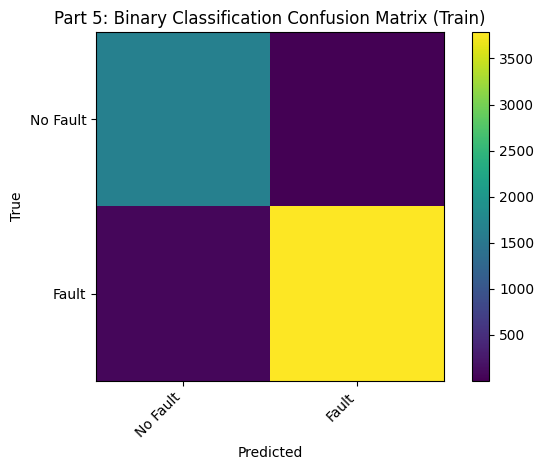


=== Binary Classification | Test ===
              precision    recall  f1-score   support

    No Fault     0.9686    0.9986    0.9834       710
       Fault     0.9994    0.9861    0.9927      1649

    accuracy                         0.9898      2359
   macro avg     0.9840    0.9923    0.9880      2359
weighted avg     0.9901    0.9898    0.9899      2359



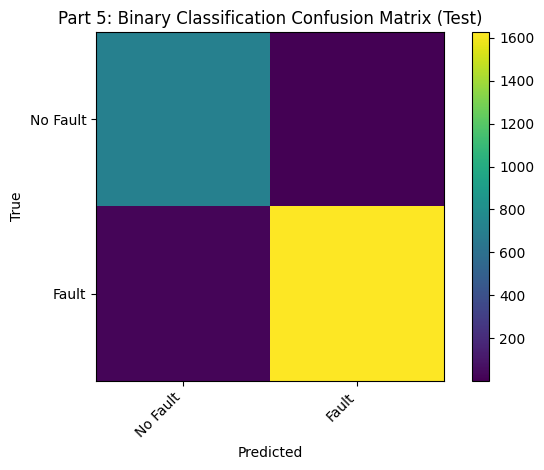

In [66]:
import torch.nn.functional as F

@torch.no_grad()
def predict_binary(model, X_np, threshold=0.5):
    model.eval()
    X_t = torch.from_numpy(X_np).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy()
    pred_labels = (probs >= threshold).astype(int).flatten()
    return pred_labels


pred_train_binary = predict_binary(model_binary, X_train_scaled)
pred_test_binary  = predict_binary(model_binary, X_test_scaled)


print('\n=== Binary Classification | Train ===')
print(classification_report(y_train_binary, pred_train_binary, target_names=['No Fault', 'Fault'], digits=4))
cm_train_binary = confusion_matrix(y_train_binary, pred_train_binary, labels=[0, 1])
plot_cm(cm_train_binary, 'Part 5: Binary Classification Confusion Matrix (Train)', ['No Fault', 'Fault'])

print('\n=== Binary Classification | Test ===')
print(classification_report(y_test_binary, pred_test_binary, target_names=['No Fault', 'Fault'], digits=4))
cm_test_binary = confusion_matrix(y_test_binary, pred_test_binary, labels=[0, 1])
plot_cm(cm_test_binary, 'Part 5: Binary Classification Confusion Matrix (Test)', ['No Fault', 'Fault'])